# Predicting Major Power Outages

**Jiawei Yang, Zhixing Jiang**

## Summary of Findings


### Introduction
TODO

### Baseline Model
TODO

### Final Model
TODO

### Fairness Analysis
TODO

### Introduction
Based on the dataset of major power outages happened in the United State during recent years, our ultimate goal in thsi project is to predict the durtaion of the power outage given various characteristics that pertain to directly to the specific instance of power outage and indirectly to the area where the outage takes place.

We chose the response variable to be `outage.duration`: a continous varaible with in the unit of minutes. We chose it since it accurately quantify the length of duration of outages and is given in the data set (compared to other possible option such as duration recorded in days, which means a drop in granularity of our model)

Since we attempt to predict a continous outcome, we use regression-based algorithm to build the model: we end up using decision tree regression after comparing it to KNN regression and linear regression. Therefore, we use two main metrics to evaluate the performance of our model: Mean Squared Error and R-squared.

### Baseline Model
In the prediction process, we assume that the model is used to predict the duration of a power outage right after the happening of that power outage. Therefore the following features from the original data set could not be used as input variables, since they are by natural unobserved at the point of outage happenings:
1. The end time of outage: this directly tells you the outage durtaion.
2. The number of customer affacted: we assume this statistic is collected/estiamted at least some time after one outage happening.

We include the following features in the model:
1. State: the state in which the outage took place, originally recorded as categorical strings with 50+ levels. (One-hot encoded in the model)
2. Cause: the description of cause of outage, originally recorded as categorical stirngs with 20+ levels. (One-hot encoded in the model) One may argue the cause or reason of the outage is not revealed immediately after the outage happening. (Since it may take time for the company to investigate) We are aware of such potential draw back, but decided to include this feature in the model assuming the company would know right away why an outage happens.
3. Cause Detail: the detail description of the cause in cateogory, orginally recorded as cartegorical strings with 50+ levels(One-hot encoded in the model). We are choosing this feature in the model also assuming the company would know right away because incidents like heavy wind or winter storm are easily spotted.

We use train-test split and cross validation to pick the model that maximize both in-sample and out-of-sample performance: specifically, we pick the best hyperparameter, max depth, of the prediction tree based on R-sqaured.

### Final Model
On top of the features present in the baseline model, we include the following three features in the final model, hoping to improve performance. The additional features are results of feature engineering based on both information recorded in the model and additional data we collected (during project 3). Feature engineering is done by `ColumnTransformer` classes we define.

We believe that extreme weather could hinder the process of restoring a power outage and therefore influence the duration of power outage. We further specify 'extreme weather' to be hot summer and cold winder by encoding the power outages with the following two features.

1. `hot_summer`: a binary encoding, `True` if the power outage took place both:
<br>
$\;\;\;\;\;\;$   in one of the months: June, July or August
<br>
$\;\;\;\;\;\;$   in a state where the average summer temperature is above xx degree celsius.
2. `cold_winter`: a  binary encoding, `True` if the power outage took place both:
<br>
$\;\;\;\;\;\;$   in one of the months: December, January or February
<br>
$\;\;\;\;\;\;$   in a state where the average winter temperature is below 0 degree celsius.

In addition, we introduce another feature from the orginal dataset "outage.start.time". However, we believe that we cannot treat it as continuous, so we created a function to discretize the column. We split the day into four periods of time: Morning (5 am to 12 pm), Afternoon (12 pm to 5 pm), Evening (5 pm to 9 pm), and Night (9 pm to 4 am).

During our exploratory 

## Code

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures

### Load and Cleaning

In [20]:
#Convert all column names to lower case
outage_org = pd.read_excel('outage.csv')
outage_org.columns = [t.lower() for t in outage_org.columns]
outage_org.columns

Index(['obs', 'year', 'month', 'u.s._state', 'postal.code', 'nerc.region',
       'climate.region', 'anomaly.level', 'climate.category',
       'outage.start.date', 'outage.start.time', 'outage.restoration.date',
       'outage.restoration.time', 'cause.category', 'cause.category.detail',
       'hurricane.names', 'outage.duration', 'demand.loss.mw',
       'customers.affected', 'res.price', 'com.price', 'ind.price',
       'total.price', 'res.sales', 'com.sales', 'ind.sales', 'total.sales',
       'res.percen', 'com.percen', 'ind.percen', 'res.customers',
       'com.customers', 'ind.customers', 'total.customers', 'res.cust.pct',
       'com.cust.pct', 'ind.cust.pct', 'pc.realgsp.state', 'pc.realgsp.usa',
       'pc.realgsp.rel', 'pc.realgsp.change', 'util.realgsp', 'total.realgsp',
       'util.contri', 'pi.util.ofusa', 'population', 'poppct_urban',
       'poppct_uc', 'popden_urban', 'popden_uc', 'popden_rural',
       'areapct_urban', 'areapct_uc', 'pct_land', 'pct_water_tot',
    

In [21]:
def remove_na(df):
    return df.loc[~df.isna().any(axis = 1).values]

In [22]:
#Cleaning the dataframe: Extract only three columns: u.s._state, cause.category, and outage.duration
#                        Remove all nans rows from the dataframe
#                        Reset the index
selected_cols = ['u.s._state', 'cause.category', 'outage.duration', 'outage.start.time','cause.category.detail']
sub = outage_org[selected_cols]
sub = remove_na(sub).reset_index(drop = True)
sub.head()

,u.s._state,cause.category,outage.duration,outage.start.time,cause.category.detail
0,Minnesota,intentional attack,1.0,18:38:00,vandalism
1,Minnesota,severe weather,3000.0,20:00:00,heavy wind
2,Minnesota,severe weather,2550.0,04:30:00,thunderstorm
3,Minnesota,severe weather,1860.0,15:00:00,winter storm
4,Minnesota,severe weather,2970.0,20:30:00,tornadoes


<AxesSubplot:ylabel='Frequency'>

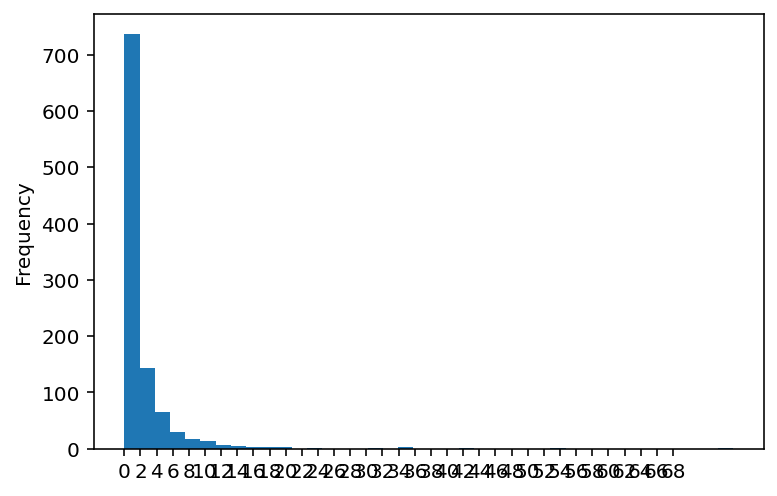

In [36]:
(sub['outage.duration']/(60*24)).plot(kind = 'hist', bins = 40, xticks = range(0,70,2))

In [44]:
days = sub['outage.duration']/(60*24)
(days < 1).mean(), (days < 3).mean(), (days >= 3).mean()

(0.6040856031128404, 0.816147859922179, 0.18385214007782102)

In [48]:
def encode_duration(x):
    duration_days = x/(60*24)
    if duration_days <= 1:
        return '<= 1 day'
    elif duration_days <= 3:
        return '<= 3 days '
    else:
        return 'above'

In [55]:
sub['duration.encoded'] = sub['outage.duration'].apply(encode_duration)
sub.head()

,u.s._state,cause.category,outage.duration,outage.start.time,cause.category.detail,duration.encoded
0,Minnesota,intentional attack,1.0,18:38:00,vandalism,<= 1 day
1,Minnesota,severe weather,3000.0,20:00:00,heavy wind,<= 3 days
2,Minnesota,severe weather,2550.0,04:30:00,thunderstorm,<= 3 days
3,Minnesota,severe weather,1860.0,15:00:00,winter storm,<= 3 days
4,Minnesota,severe weather,2970.0,20:30:00,tornadoes,<= 3 days


In [58]:
pd.DataFrame({'Weather': ['hot', 'cold', 'hot', 'hot', 'so-so', 'cold', 'hot','so-so'],
             'predictied_correct': [True, False, True, True, False, True, False, True]})

,Weather,predictied_correct
0,hot,True
1,cold,False
2,hot,True
3,hot,True
4,so-so,False
5,cold,True
6,hot,False
7,so-so,True


### Baseline Model

In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier

In [61]:
#Build the model by transforming u.s._state and cause.category columns using one hot encoder from sklearn
#Fit the data using DecisionTreeRegressor with max_depth = 5 and find the R-square of the prediction
prepro = ColumnTransformer(
    transformers = [('ohe', OneHotEncoder(handle_unknown='ignore'), ['u.s._state', 'cause.category','cause.category.detail'])],
    remainder = 'passthrough'
)
ppl_base = Pipeline(
    steps = [
        ('prepro', prepro),
        ('dtree', DecisionTreeClassifier(max_depth = 5))
    ]
)
ppl_base.fit(sub.drop(
    columns = ['outage.duration','outage.start.time', 'duration.encoded']), sub['duration.encoded'])
ppl_base.score(sub.drop(
    columns = ['outage.duration','outage.start.time', 'duration.encoded']), sub['duration.encoded'])

0.7013618677042801

In [7]:
#Dictionary of hyper parameter used to find the best fit
hypers = {
    'dtree__max_depth':[2,3,4,5,6,7,8,9,10,11,12,13,14,15]
}

In [69]:
#Apply GridSearchCV on the baseline model to find the best-fit hyperparameter
X_train, X_test, y_train, y_test = train_test_split(
    sub.drop(columns = ['outage.duration','outage.start.time', 'duration.encoded']),
    sub['duration.encoded'],)
searcher = GridSearchCV(ppl_base, hypers, cv = 5)
searcher.fit(X_train, y_train)
searcher.best_params_, searcher.score(X_train, y_train), searcher.score(X_test, y_test)

({'dtree__max_depth': 6}, 0.7341115434500648, 0.669260700389105)

### Final Model

In [75]:
#Import temp_state.csv which contains the state name, the average temperature in winter by state, 
#and the average temperature in summer by state
temp_df = pd.read_csv('temp_state.csv').drop(columns = ['Unnamed: 0'])
temp_df.head()

,u.s._state,winter_avg_temp,summer_avg_temp
0,Alabama,8.1,25.9
1,Alaska,-16.3,11.3
2,Arizona,6.4,25.6
3,Arkansas,5.3,26.0
4,California,7.9,23.0


In [76]:
#Merge temp_df to the final_sub 
final_sub = sub.copy()
#final_sub['long_by_state'] = col
final_sub = final_sub.merge(temp_df, left_on = 'u.s._state', right_on = 'u.s._state')
final_sub.head()

,u.s._state,cause.category,outage.duration,outage.start.time,cause.category.detail,duration.encoded,winter_avg_temp,summer_avg_temp
0,Minnesota,intentional attack,1.0,18:38:00,vandalism,<= 1 day,-10.9,19.3
1,Minnesota,severe weather,3000.0,20:00:00,heavy wind,<= 3 days,-10.9,19.3
2,Minnesota,severe weather,2550.0,04:30:00,thunderstorm,<= 3 days,-10.9,19.3
3,Minnesota,severe weather,1860.0,15:00:00,winter storm,<= 3 days,-10.9,19.3
4,Minnesota,severe weather,2970.0,20:30:00,tornadoes,<= 3 days,-10.9,19.3


In [77]:
#Helper function that converts time of a day to four periods of time
def descretize_startTime(time):
    #Morning 5 am to 12 pm (noon)
    #Afternoon 12 pm to 5 pm.
    #Evening 5 pm to 9 pm.
    #Night 9 pm to 4 am.
    if time.hour >= 5 and time.hour < 12:
        return 'Morning'
    elif time.hour >= 12 and time.hour < 17:
        return 'Afternoon'
    elif time.hour >= 17 and time.hour < 21:
        return 'Evening'
    else:
        return 'Night'

In [78]:
#Function that apply descretize_startTime on a series/dataframe and return a dataframe
def change_starttime(ser):
    df = pd.DataFrame(ser)
    return pd.DataFrame(df['outage.start.time'].apply(descretize_startTime))

In [79]:
discretize_time = Pipeline([
        ('discretize_hour', FunctionTransformer(change_starttime)),
        ('one_hot_encoding', OneHotEncoder())
        ]
    )

In [80]:
#Function that converts summer temperature into boolean to define whether the summer is hot
def transform_hot(temp):
    df = pd.DataFrame(temp)
    def check_warm(x):
        if x >= 25:
            return True
        else:
            return False
    return pd.DataFrame(df['summer_avg_temp'].apply(check_warm))
hot_changed = Pipeline([
        ('temp_to_hot', FunctionTransformer(transform_hot)),
        ('one_hot_encoding', OneHotEncoder())
        ]
    )

In [81]:
#Function that converts winter temperature into boolean to define whether the winter is cold
def transform_cold(temp):
    df = pd.DataFrame(temp)
    def check_cold(x):
        if x <= 0 :
            return True
        else:
            return False
    return pd.DataFrame(df['winter_avg_temp'].apply(check_cold))
cold_changed = Pipeline([
        ('temp_to_cold', FunctionTransformer(transform_cold)),
        ('one_hot_encoding', OneHotEncoder())
        ]
    )

In [90]:
#Build the model by transforming u.s._state, cause.category, 
#and long_by_state columns using one hot encoder from sklearn
#Fit the data using DecisionTreeRegressor with max_depth = 5 and find the R-square of the prediction
prepro = ColumnTransformer(
    transformers = [('ohe', OneHotEncoder(handle_unknown='ignore'), ['u.s._state', 'cause.category',
                                                                     'cause.category.detail']),
                    ('start_time_discretize', discretize_time, ['outage.start.time']),
                   ('cold_changed_prepro', cold_changed, ['winter_avg_temp']),
                   ('hot_changed_prepro', hot_changed, ['summer_avg_temp'])],
    remainder = 'passthrough'
)
ppl_improve = Pipeline(
    steps = [
        ('prepro', prepro),
        ('dtree2', DecisionTreeClassifier(max_depth = 5))
        
    ]
)

ppl_improve.fit(final_sub.drop(columns = ['duration.encoded', 'outage.duration']), final_sub['duration.encoded'])
ppl_improve.score(final_sub.drop(columns = ['duration.encoded', 'outage.duration']), final_sub['duration.encoded'])

0.7062256809338522

In [91]:
#Dictionary of hyper parameter used to find the best fit
hypers2 = {
    'dtree2__max_depth':[2,3,4,5,6,7,8,9,10,11,12,13,14,15],
    'dtree2__splitter': ['best', 'random'],
    #'dtree2__min_samples_split': [2, 3, 5, 7, 10, 15, 20],
}

In [93]:
#Apply GridSearchCV on the baseline model to find the best-fit hyperparameter
X2_train, X2_test, y2_train, y2_test = train_test_split(
    final_sub.drop(columns = ['duration.encoded', 'outage.duration']), final_sub['duration.encoded'])
searcher = GridSearchCV(ppl_improve, hypers2, cv = 5)
searcher.fit(X2_train, y2_train)
searcher.best_params_, searcher.score(X2_train, y2_train), searcher.score(X2_test, y2_test)

({'dtree2__max_depth': 14, 'dtree2__splitter': 'best'},
 0.8313878080415046,
 0.6926070038910506)

In [96]:
#Apply GridSearchCV on the baseline model to find the best-fit hyperparameter
X2_train, X2_test, y2_train, y2_test = train_test_split(
    final_sub.drop(columns = ['duration.encoded', 'outage.duration']), final_sub['duration.encoded'])
searcher = GridSearchCV(ppl_improve, hypers2, cv = 5)
searcher.fit(X2_train, y2_train)
searcher.best_params_, searcher.score(X2_train, y2_train), searcher.score(X2_test, y2_test)

({'dtree2__max_depth': 14, 'dtree2__splitter': 'best'},
 0.8184176394293126,
 0.708171206225681)

### Fairness Analysis

Null Hypothesis: Our model is fair. The R-Squared for the lower 90 percentile is roughly the same as the R-Squared of the top 10 percentile in outage duration by state. <br>
Alternative Hypothesis: Our model is unfair. The R-Squared for the lower 90 percentile is higher than the R-Squared of the top 10 percentile in outage duration by state.

In [ ]:
final_sub

In [ ]:
state = final_sub['u.s._state'].unique()
state

In [ ]:
shuffled_lst = pd.Series([],dtype=object)
for x in state:
    shuffled_lst = shuffled_lst.append(pd.Series(np.random.permutation(final_sub[final_sub['u.s._state'] == x]['long_by_state'])), ignore_index = True)

In [ ]:
shuffled_lst

In [ ]:
final_sub_copy = final_sub.copy()
diff_lst = []
for _ in range(100):
    shuffled_lst = pd.Series([],dtype=object)
    for x in state:
        #Shuffle the long_by_state columns within ea
        shuffled_lst = shuffled_lst.append(pd.Series(np.random.permutation(final_sub
                                            [final_sub['u.s._state'] == x]['long_by_state'])), ignore_index = True)
    copy_false = final_sub_copy[final_sub_copy['long_by_state'] == False]
    ppl_improve.fit(copy_false.drop(columns = ['outage.duration']), copy_false['outage.duration'])
    false_score = ppl_improve.score(copy_false.drop(columns = ['outage.duration']), copy_false['outage.duration'])

    copy_true = final_sub_copy[final_sub_copy['long_by_state'] == True]
    ppl_improve.fit(copy_true.drop(columns = ['outage.duration']), copy_true['outage.duration'])
    true_score = ppl_improve.score(copy_true.drop(columns = ['outage.duration']), copy_true['outage.duration'])
    diff_lst.append(false_score - true_score)

In [ ]:
p_val = np.mean([np.array(diff_lst) > 0])
p_val